In [1]:
# Data Analysis
import pandas as pd
import numpy as np
import math
from sklearn import preprocessing
from scipy import stats
import statsmodels.stats.multitest as smm

# Plotting libraries
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import matplotlib.ticker as ticker
from matplotlib.lines import Line2D
from matplotlib.patches import Patch

# Other libs
import os
import pickle
import bz2

mpl.rcParams['figure.dpi'] = 300

In [2]:
# LENGTHS OF CHROMOSOMES
reference = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa"
fai = "/media/urbe/MyADrive1/Antoine/19-11-21_VariantCalling_ARC/input/reference.fa.fai"
lengths = {}
for line in open(fai, 'r') :
    s = line.strip().split()
    lengths[s[0]] = int(s[1])

In [3]:
# REPEATS DATAFRAME
repeats = "/media/urbe/MyBDrive1/Antoine/27-10-21_VariantCalling_MA/input/avaga.TEannotation.26-02-20.defragmentedDraftAnnot.bed"

reps = {"CHR":[], "START":[], "END":[]}
for line in open(repeats, "r") :
    s = line.strip().split("\t")
    reps["CHR"].append(s[0])
    reps["START"].append(int(s[1]))
    reps["END"].append(int(s[2]))
    
repdf = pd.DataFrame().from_dict(reps)

In [4]:
ancestrally_homozygous = [
    (1, 16.0, 18.3),
    (2, 15.8, 16.3),
    (2, 0.0, 0.3),
    (4, 0.0, 0.25),
    (5, 0.0, 0.5),
    (5, 4.6, 6.6),
    (5, 9.9, 14.5),
    (6, 13.55, 13.9),
]

In [5]:
ccycle = plt.rcParams['axes.prop_cycle'].by_key()['color']

colors = {
    "DEL":ccycle[3], # Heterozygous deletion
    "DUP":ccycle[2], # Duplication
    "LOH":ccycle[9], # LOH
    "RES":ccycle[8], # Restoration (cov = 1 previously 0.5)
    "HDE":ccycle[5], # Homozygous deletion
    "ancestor":ccycle[0],
    "control":ccycle[4],
    "midpoint":ccycle[2],
    "endpoint":ccycle[1], # and "offspring" for ARC
    "nanopore":ccycle[3],
}

print(colors)

{'DEL': '#d62728', 'DUP': '#2ca02c', 'LOH': '#17becf', 'RES': '#bcbd22', 'HDE': '#8c564b', 'ancestor': '#1f77b4', 'control': '#9467bd', 'midpoint': '#2ca02c', 'endpoint': '#ff7f0e', 'nanopore': '#d62728'}


### Get summary files

In [6]:
summary_dir = "/media/urbe/MyADrive1/Antoine/2023-08-28_Analysis_GR_ME/"

ARC_samples = ['ancestor', 'P100_C8_E4', '30H_C36_E5', 'P250_C8_E3', '30D_C52_E5', '30D_C38_E4', 'P500_C16_E5', 'P100_C30_E4', '30H_C3_E5', 'P0_C27_E5', 'P500_C16_E4', '30D_C13_E3', '30D_C38_E5', 'P0_C9_E5', '30H_C48_E5', 'P250_C17_E4', 'P0_C9_E4', '30H_C3_E4', 'P100_C8_E3', 'P250_C8_E4', 'P500_C30_E3', 'P250_C17_E3', 'P500_C18_E3', 'P0_C40_E5', 'P100_C30_E3']
MA_samples = ['D5C1', 'D2C1', 'H4A4', 'D4B4_50G', 'H5A2', 'D3A3_50G', 'H3C4_50G', 'H5A2_50G', 'H5C2_50G', 'H3A4_50G', 'D4B4', 'H2C3', 'D5C1_50G', 'H5A4', 'H4A4_50G', 'H2A3', 'D2C3_50G', 'H2B4_50G', 'D3A3', 'D2B3', 'H3A4', 'D3A1', 'H5A3', 'D5B3', 'D5C3', 'D5C3_50G', 'D2C3', 'H4C2', 'H5A4_50G', 'D2C1_50G', 'H2B4', 'D4A3', 'H5C2', 'D2A1', 'D2B3_50G', 'H3C4']
all_samples = ARC_samples+MA_samples
all_files_per_sample = {sm:{'AF':None,'COV':None} for sm in all_samples}

files = os.listdir(summary_dir)
for file in files :
    print(file)
    if file == "GR_P500C18E3_AF_COV_Illumina_ONT.pkl.bz2" :
        continue
    if "_AF_" in file :
        sample = file.split("_AF_windows.pbz2")[0]
        all_files_per_sample[sample]["AF"] = file
    elif "_COV_" in file :
        sample = file.split("_COV_windows.pbz2")[0]
        all_files_per_sample[sample]["COV"] = file
    else :
        print("ERROR", file)
        pass

files = [f for f in files if f.endswith("pbz2")]
print(len(files))

def get_AF_and_COV(summary_dir, dc) :
    AF = None
    COV = None
    with bz2.BZ2File(summary_dir + "/" + dc["AF"], 'rb') as f:
        AF = pickle.load(f)
    
    with bz2.BZ2File(summary_dir + "/" + dc["COV"], 'rb') as f:
        COV = pickle.load(f)
        
    return AF, COV

D4A3.clusters.LOH.pkl.bz2
ERROR D4A3.clusters.LOH.pkl.bz2
P0_C9_E4.clusters.LOH.pkl.bz2
ERROR P0_C9_E4.clusters.LOH.pkl.bz2
P100_C8_E4_AF_windows.pbz2
30D_C52_E5_AF_windows.pbz2
D2C3_50G_AF_windows.pbz2
30H_C36_E5.clusters.LOH.pkl.bz2
ERROR 30H_C36_E5.clusters.LOH.pkl.bz2
30H_C3_E4_COV_windows.pbz2
D2C3_50G_COV_windows.pbz2
D5C3.clusters.LOH.pkl.bz2
ERROR D5C3.clusters.LOH.pkl.bz2
P250_C17_E4.clusters.LOH.pkl.bz2
ERROR P250_C17_E4.clusters.LOH.pkl.bz2
H2B4.clusters.LOH.pkl.bz2
ERROR H2B4.clusters.LOH.pkl.bz2
20_Deletion_Nanopore_Simulation.ipynb
ERROR 20_Deletion_Nanopore_Simulation.ipynb
H2A3_AF_windows.pbz2
P0_C9_E5.clusters.LOH.pkl.bz2
ERROR P0_C9_E5.clusters.LOH.pkl.bz2
D2A1_AF_windows.pbz2
P250_C17_E4_COV_windows.pbz2
H4A4_AF_windows.pbz2
P250_C8_E3_COV_windows.pbz2
P250_C8_E4_COV_windows.pbz2
H3A4_50G_COV_windows.pbz2
16_Generalized_Linear_Model.ipynb
ERROR 16_Generalized_Linear_Model.ipynb
ancestor_COV_windows.pbz2
D2B3.clusters.LOH.pkl.bz2
ERROR D2B3.clusters.LOH.pkl.bz2
H5A3_C

### Plot function

In [7]:
def get_LOH_score(anc_AF, off_AF) :
    delta = anc_AF["AF", "mean"] - off_AF["AF", "mean"]
    return delta.apply(lambda x: 2*abs(x)) # 1.0 = LOH, 0.0 = no changes

def get_COV_score(anc_COV, off_COV) :
    return off_COV["nCOV", "mean"] - anc_COV["nCOV", "mean"]

In [8]:
def plot_data(
    summary_dir, all_files_per_sample,
    contig, sample, lengths, colors,
    control_sample = None,
    cov_y_lim = (-0.6, 0.6),
    cov_y_ticks = [-0.5, -0.25, 0.0, 0.25, 0.5],
    af_y_ticks = [0.0, 0.25,0.5,0.75,1.0],
    lw = 1.5, xsize=4, ysize=3,
    text=None,
) :
    
    # Sample data
    dc_files = all_files_per_sample[sample]
    AF, COV = get_AF_and_COV(summary_dir, dc_files)
    
    dc_files = all_files_per_sample[sample+"_50G"]
    mid_AF, mid_COV = get_AF_and_COV(summary_dir, dc_files)
    if control_sample is not None :
        dc_files = all_files_per_sample[control_sample]
        ctl_AF, ctl_COV = get_AF_and_COV(summary_dir, dc_files)
        
    # Ancestor data
    anc_AF, anc_COV = get_AF_and_COV(summary_dir, all_files_per_sample["ancestor"])
    
    # Compute scores
    AF_score = get_LOH_score(anc_AF[contig], AF[contig])
    COV_score = get_COV_score(anc_COV[contig], COV[contig])
    
    # Midpoint
    mid_AF_score = get_LOH_score(anc_AF[contig], mid_AF[contig])
    mid_COV_score = get_COV_score(anc_COV[contig], mid_COV[contig])
    
    if control_sample is not None :
        ctl_AF_score = get_LOH_score(anc_AF[contig], ctl_AF[contig])
        ctl_COV_score = get_COV_score(anc_COV[contig], ctl_COV[contig])
        
    length = lengths[contig]

    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(xsize,ysize))

    ax = axs[0]
    ax.plot(AF[contig]["POS", "mean"], AF_score, lw=lw, color=colors["endpoint"], zorder=8, label="{}".format(sample))
    ax.plot(AF[contig]["POS", "mean"], mid_AF_score, lw=lw, color=colors["midpoint"], zorder=5, label="{} (midpoint)".format(sample))
    if control_sample is not None :
        ax.plot(ctl_AF[contig]["POS", "mean"], ctl_AF_score, lw=lw, color=colors["ancestor"], zorder=2, label="{} (control)".format(control_sample))

    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = ["" for i in xticks]
    ax.set_xticklabels(ticklabels)

    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("LOH Score", fontsize=8)
    ax.set_yticks(af_y_ticks)
    
    ax.legend(loc="best", fontsize=6, frameon=True,)

    ax = axs[1]
    ax.plot(COV[contig]["POS", "mean"], COV_score, lw=lw, color=colors["endpoint"], zorder=8)
    ax.plot(COV[contig]["POS", "mean"], mid_COV_score, lw=lw, color=colors["midpoint"], zorder=5)
    if control_sample is not None :
        ax.plot(ctl_COV[contig]["POS", "mean"], ctl_COV_score, lw=lw, color=colors["ancestor"], zorder=2)
        

    ax.tick_params(labelsize=8)
    ax.set_xlabel("Position along Chromosome {}".format(contig[-1]), fontsize=8)
    ax.set_ylim(cov_y_lim[0], cov_y_lim[1])
    ax.set_ylabel(r"$\Delta$ Coverage", fontsize=8)
    ax.set_yticks(cov_y_ticks)
    
    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = [str(int(i/1e6))+"M" for i in xticks]
    ax.set_xticklabels(ticklabels)

    for ax in axs :
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', zorder=1, lw=0.5, color=[0.5,0.5,0.5])
        ax.tick_params(axis="y", length=0.5)
        ax.tick_params(labelsize=6)

        ax.set_xlim(0, max(COV[contig]["POS", "first"])+1e4) #+1e5)
        
    ax = axs[1]
    if text is not None :
        
        s, e = text[0], text[1]
        if text[2] == "M" :
            m = 1e6
        elif text[2] == "K" :
            m = 1e3
        else :
            m = 1
        
        y = text[3]
        
        ax.plot([s, e], [y, y], color="k", lw=0.5)
        
        x = s + (e-s)/2
        stxt = "{:.1f}{}" if text[5] == 1 else "{:.0f}{}"
        #print(stxt)
        stxt = stxt.format( (e-s)/m, text[2] )
        #print(stxt)
        
        fontsize = text[6]
        
        if text[4] : # true = below :
            ax.text(x=x, y=y, s=stxt, ha="center", va="bottom", fontsize=fontsize)
        else :
            ax.text(x=x, y=y-0.02, s=stxt, ha="center", va="top", fontsize=fontsize)

    plt.subplots_adjust(hspace=0.1)

    plt.show()

# Figure 2a (ME sample D5C3 C6)

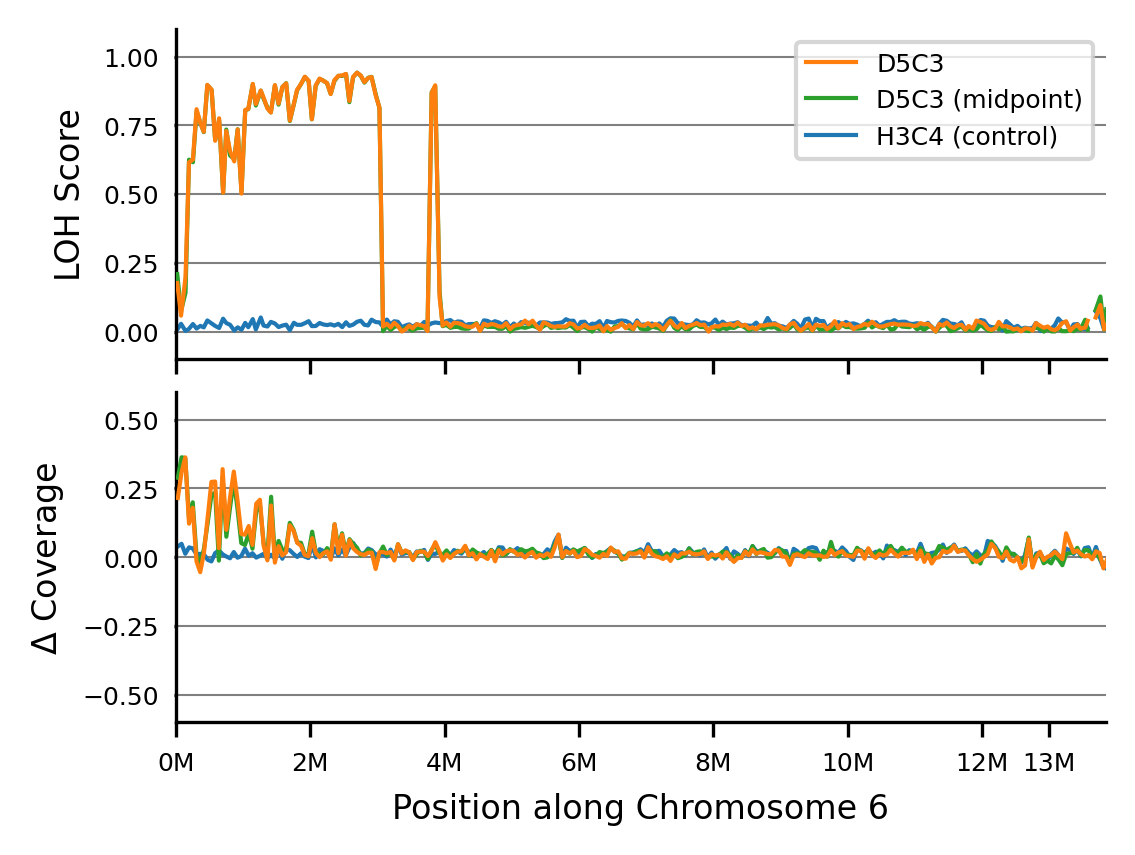

In [11]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_6", sample="D5C3",
    control_sample = "H3C4",
    lengths=lengths, colors=colors, lw=1.0,
    #cov_y_lim=(-0.6, 1.1),
    #cov_y_ticks=[-0.5, -0.25, 0.0, 0.25, 0.5, 0.75, 1.0]
)

# Previous figures

### Previous Figure 3a and 3b

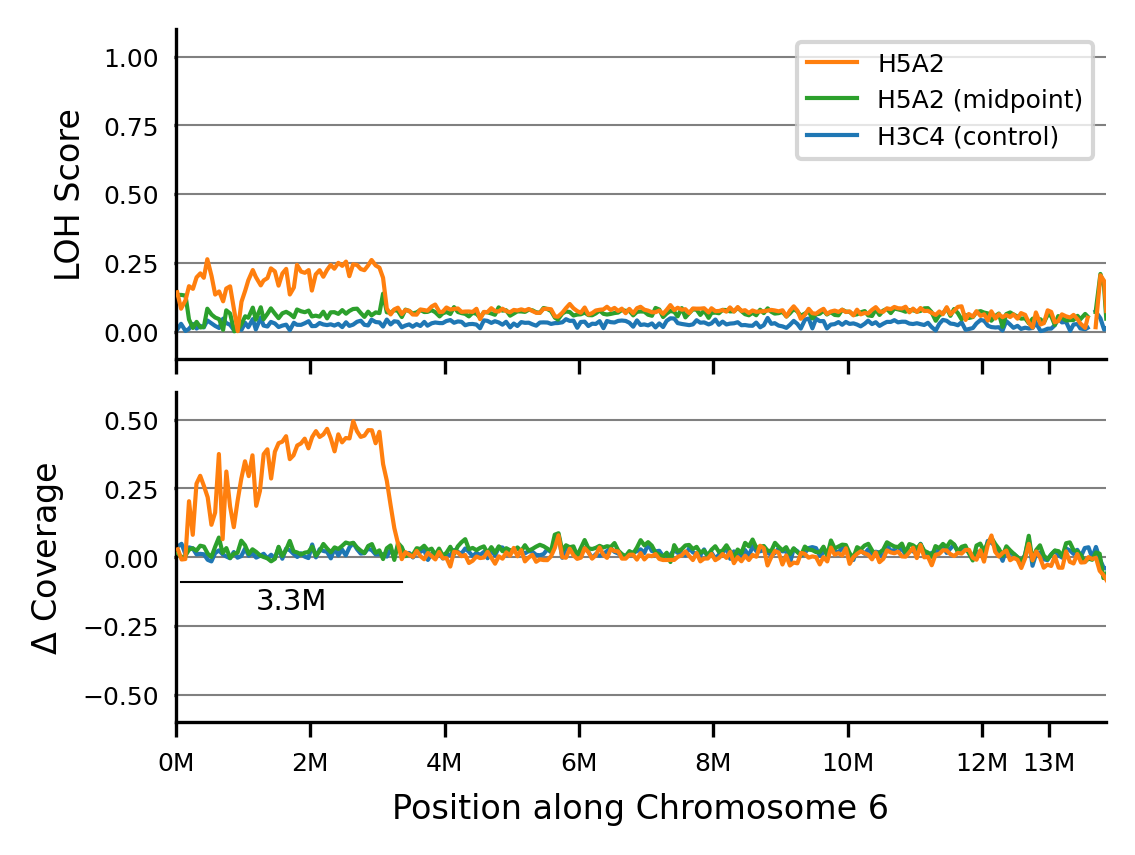

In [12]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_6", sample="H5A2",
    control_sample = "H3C4",
    lengths=lengths, colors=colors, lw=1.0,
    text=(70000, 3370000, "M", -0.09, False, 1, 7),
)

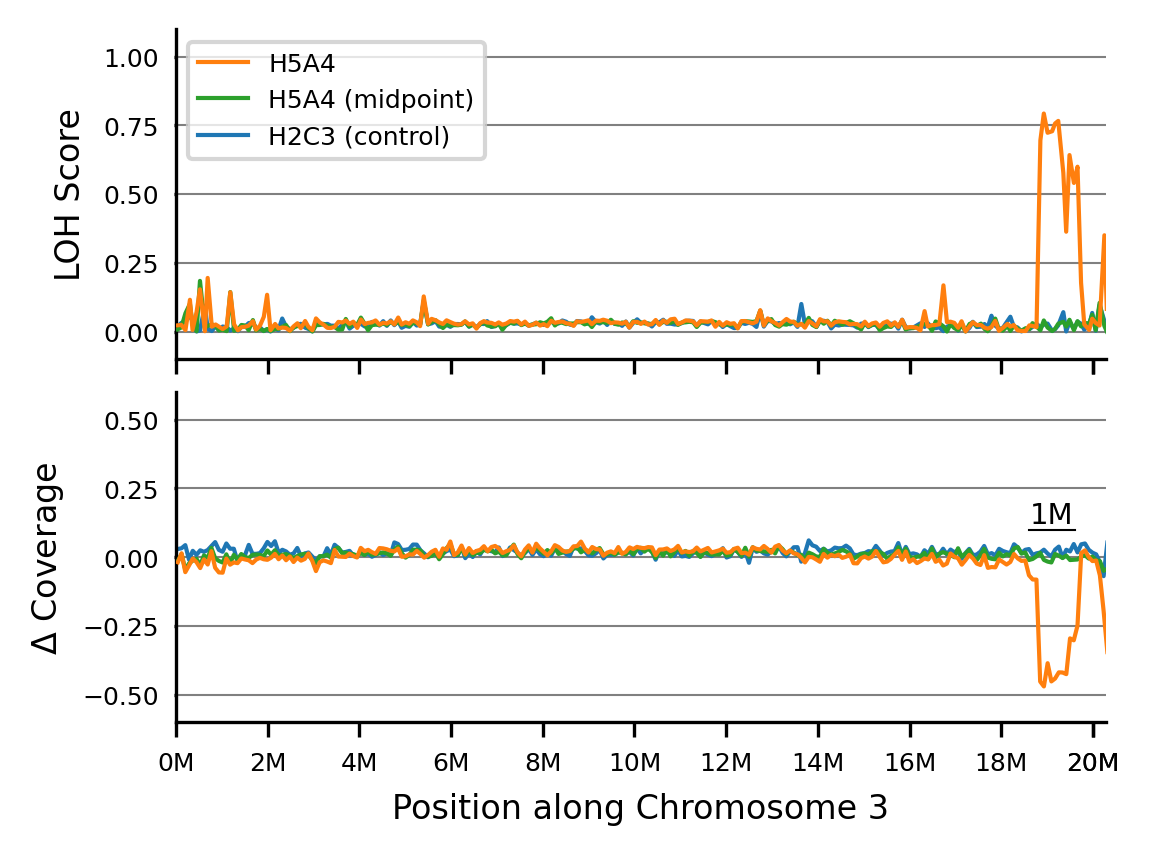

In [13]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_3", sample="H5A4",
    control_sample = "H2C3",
    lengths=lengths, colors=colors, lw=1.0,
    text=(18600000, 19600000, "M", 0.1, True, 0, 7),
) # HET DELETION

# Supp. Fig. H4A4

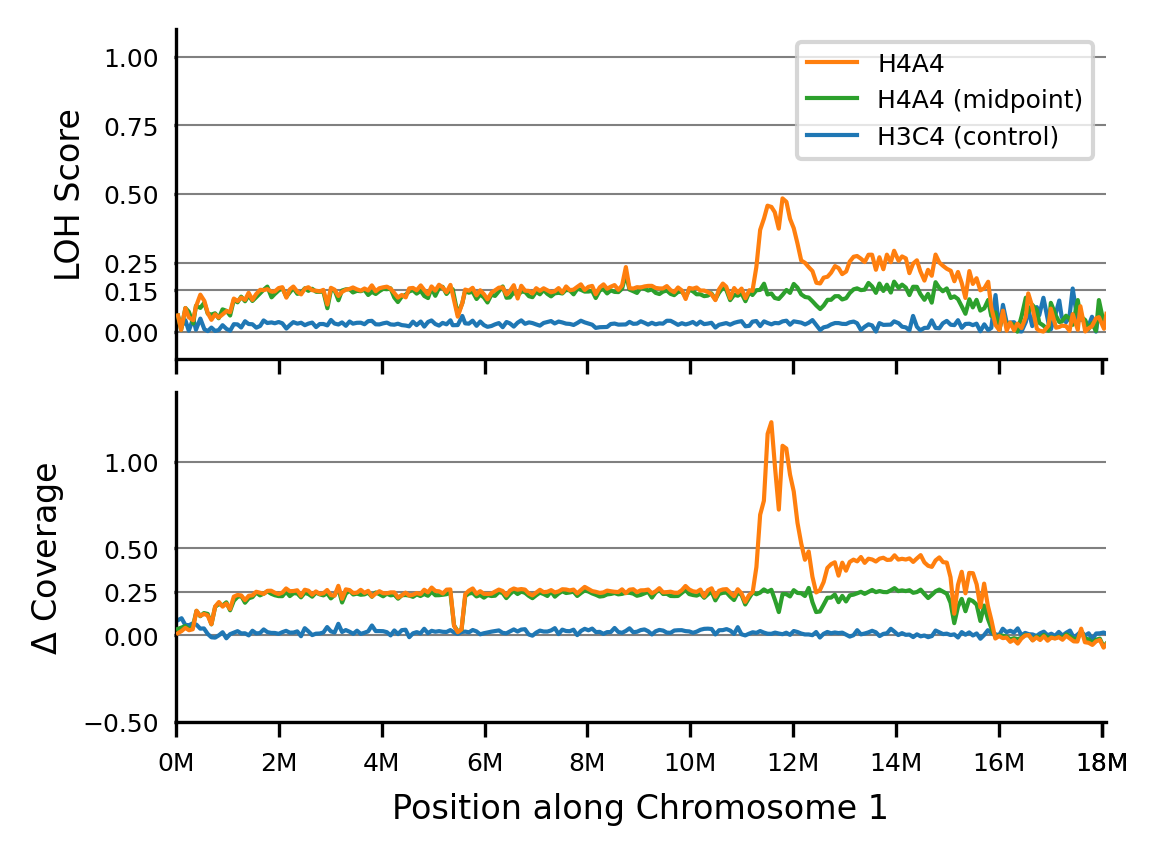

In [13]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_1", sample="H4A4",
    control_sample = "H3C4",
    lengths=lengths, colors=colors, lw=1.0,
    af_y_ticks = [0.0, 0.15, 0.25, 0.5, 0.75, 1.0],
    cov_y_lim=(-0.5, 1.4), cov_y_ticks = [-0.5, 0.0, 0.25, 0.5, 1.0]
)

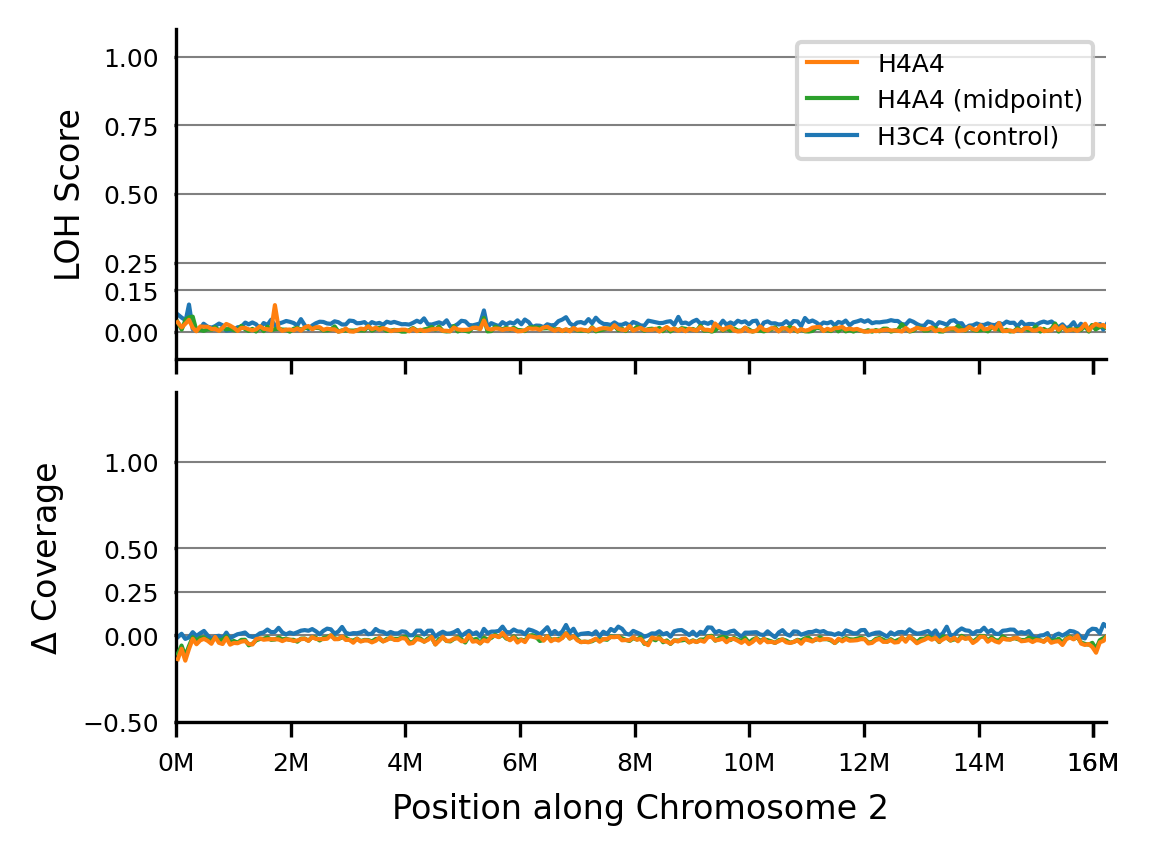

In [14]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_2", sample="H4A4",
    control_sample = "H3C4",
    lengths=lengths, colors=colors, lw=1.0,
    af_y_ticks = [0.0, 0.15, 0.25, 0.5, 0.75, 1.0],
    cov_y_lim=(-0.5, 1.4), cov_y_ticks = [-0.5, 0.0, 0.25, 0.5, 1.0]
)

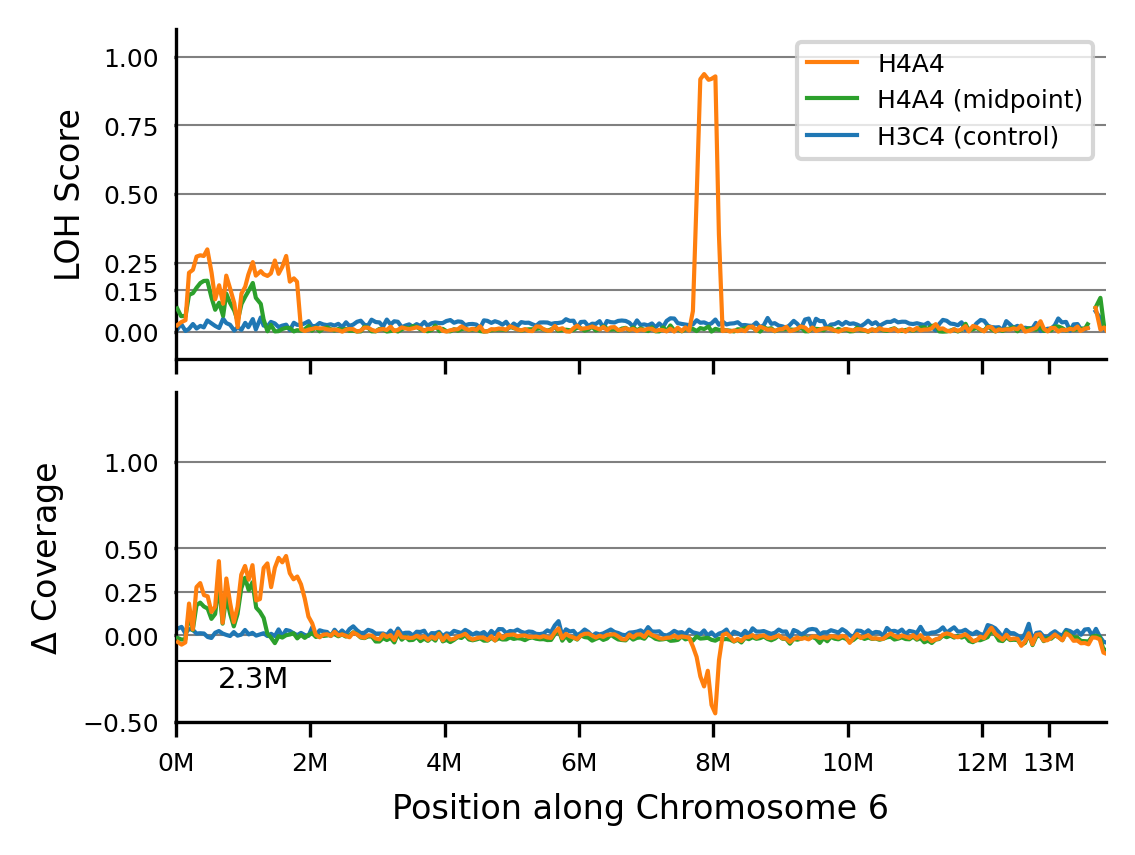

In [12]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_6", sample="H4A4",
    control_sample = "H3C4",
    lengths=lengths, colors=colors, lw=1.0,
    af_y_ticks = [0.0, 0.15, 0.25, 0.5, 0.75, 1.0],
    cov_y_lim=(-0.5, 1.4), cov_y_ticks = [-0.5, 0.0, 0.25, 0.5, 1.0],
    text=(0, 2300000, "M", -0.15, False, 1, 7),
)

# Supp. Fig. AF, cov comparison to LOH score and Delta Cov

In [16]:
def plot_data_all_metrics(
    summary_dir, all_files_per_sample,
    contig, sample, lengths, colors,
    control_sample = None,
    cov_y_lim = (-0.6, 0.6),
    cov_y_ticks = [-0.5, -0.25, 0.0, 0.25, 0.5],
    lw = 1.5, xsize=8, ysize=3,
) :
    
    # Sample data
    dc_files = all_files_per_sample[sample]
    print(dc_files)
    
    AF, COV = get_AF_and_COV(summary_dir, dc_files)
    if control_sample is not None :
        dc_files = all_files_per_sample[control_sample]
        ctl_AF, ctl_COV = get_AF_and_COV(summary_dir, dc_files)
        
    # Ancestor data
    anc_AF, anc_COV = get_AF_and_COV(summary_dir, all_files_per_sample["ancestor"])
    
    # Compute scores
    AF_score = get_LOH_score(anc_AF[contig], AF[contig])
    COV_score = get_COV_score(anc_COV[contig], COV[contig])
    if control_sample is not None :
        ctl_AF_score = get_LOH_score(anc_AF[contig], ctl_AF[contig])
        ctl_COV_score = get_COV_score(anc_COV[contig], ctl_COV[contig])
        
    length = lengths[contig]

    fig, axs = plt.subplots(nrows=2, ncols=2, sharex=True, figsize=(xsize,ysize))
    
    # AF in ancestor and offspring
    ax = axs[0,0]
    ax.plot(anc_AF[contig]["POS", "mean"], anc_AF[contig]["AF", "mean"], lw=lw, color=colors["ancestor"], zorder=5, label="Ancestor")
    ax.plot(AF[contig]["POS", "mean"], AF[contig]["AF", "mean"], lw=lw, color=colors["endpoint"], zorder=2, label="{}".format(sample))

    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = ["" for i in xticks]
    ax.set_xticklabels(ticklabels)

    ax.set_ylim(-0.1, 1.25)
    ax.set_ylabel("Allele\nFrequency", fontsize=8)
    afticks = [0.0, 0.25,0.5,0.75,1.0]
    ax.set_yticks(afticks)
    
    ax.legend(loc="upper right", ncol=2, fontsize=6, frameon=False,)

    ax = axs[1,0]
    ax.plot(anc_COV[contig]["POS", "mean"], anc_COV[contig]["nCOV", "mean"], lw=lw, color=colors["ancestor"], zorder=5)
    ax.plot(COV[contig]["POS", "mean"], COV[contig]["nCOV", "mean"], lw=lw, color=colors["endpoint"], zorder=2)
        

    ax.tick_params(labelsize=8)
    ax.set_xlabel("Position along Chromosome {}".format(contig[-1]), fontsize=8)
    ax.set_ylim(0.0, 1.5)
    ax.set_ylabel("Coverage", fontsize=8)
    #ax.set_yticks(cov_y_ticks)
    
    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = [str(int(i/1e6))+"M" for i in xticks]
    ax.set_xticklabels(ticklabels)
    
    ax.set_xlabel("Position along Chromosome {}".format(contig[-1]), fontsize=8)
    
    
    ax = axs[0,1]
    ax.plot(AF[contig]["POS", "mean"], AF_score, lw=lw, color=colors["endpoint"], zorder=5, label="{}".format(sample))
    if control_sample is not None :
        ax.plot(ctl_AF[contig]["POS", "mean"], ctl_AF_score, lw=lw, color=colors["midpoint"], zorder=2, label="{} (control)".format(control_sample))

    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = ["" for i in xticks]
    ax.set_xticklabels(ticklabels)

    ax.set_ylim(-0.1, 1.25)
    ax.set_ylabel("LOH Score", fontsize=8)
    afticks = [0.0, 0.25,0.5,0.75,1.0]
    ax.set_yticks(afticks)
    
    ax.legend(loc="upper right", ncol=2, fontsize=6, frameon=False,)

    ax = axs[1,1]
    ax.plot(COV[contig]["POS", "mean"], COV_score, lw=lw, color=colors["endpoint"], zorder=5)
    if control_sample is not None :
        ax.plot(ctl_COV[contig]["POS", "mean"], ctl_COV_score, lw=lw, color=colors["midpoint"], zorder=2)
        

    ax.tick_params(labelsize=8)
    ax.set_xlabel("Position along Chromosome {}".format(contig[-1]), fontsize=8)
    ax.set_ylim(cov_y_lim[0], cov_y_lim[1])
    ax.set_ylabel(r"$\Delta$ Coverage", fontsize=8)
    ax.set_yticks(cov_y_ticks)
    
    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = [str(int(i/1e6))+"M" for i in xticks]
    ax.set_xticklabels(ticklabels)

    for ax in axs.flatten() :
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', zorder=1, lw=0.5, color=[0.5,0.5,0.5])
        ax.tick_params(axis="y", length=0.5)
        ax.tick_params(labelsize=6)

        ax.set_xlim(0, max(COV[contig]["POS", "first"])+1e4) #+1e5)

    plt.subplots_adjust(hspace=0.1, wspace=0.3)

    plt.show()

{'AF': 'D5C3_AF_windows.pbz2', 'COV': 'D5C3_COV_windows.pbz2'}


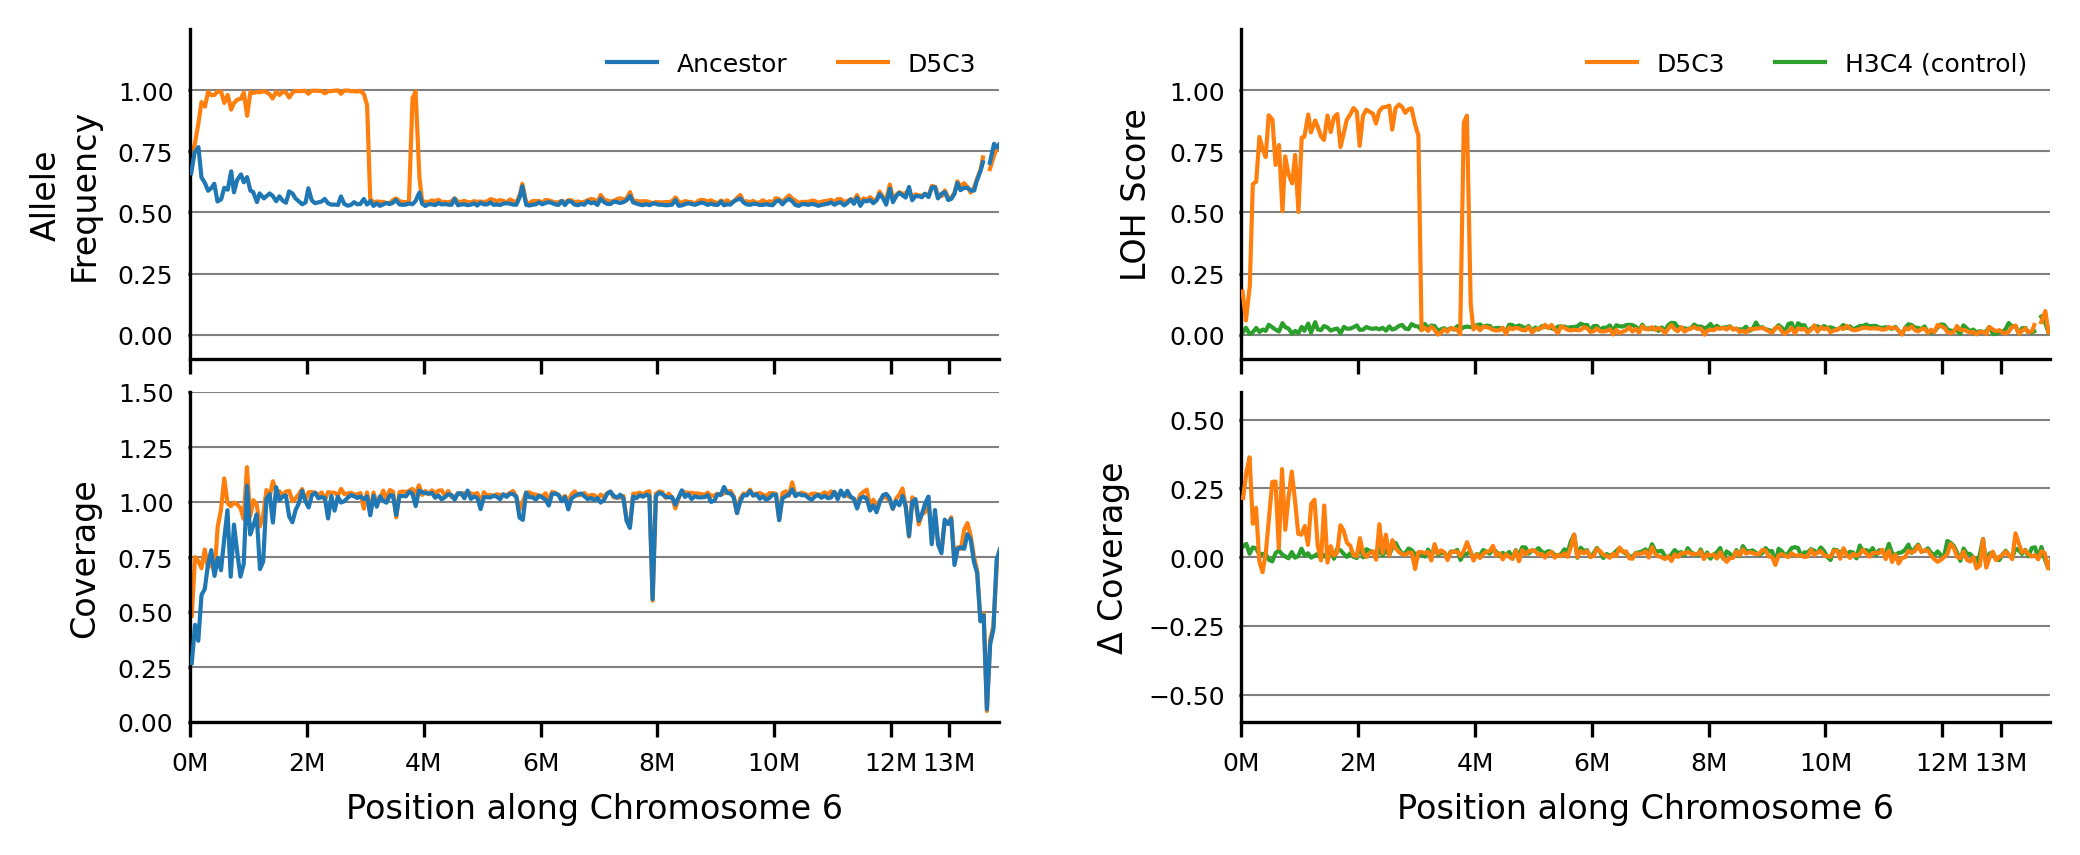

In [17]:
plot_data_all_metrics(
    summary_dir, all_files_per_sample,
    contig="Chrom_6", sample="D5C3",
    control_sample = "H3C4",
    lengths=lengths, colors=colors, lw=1.0,
)

# New figure 3 abcd

### Plot all metrics

In [9]:
def plot_data(
    summary_dir, all_files_per_sample,
    contig, sample, lengths, colors,
    control_sample = None,
    cov_y_lim = (-0.6, 0.6),
    cov_y_ticks = [-0.5, -0.25, 0.0, 0.25, 0.5],
    lw = 1.5, xsize=4, ysize=4,
    x_lim = None,
    text=None, show_midpoint=True,
) :
    
    # Sample data
    dc_files = all_files_per_sample[sample]
    AF, COV = get_AF_and_COV(summary_dir, dc_files)
    
    has_50g = False
    if show_midpoint :
        try :
            dc_files = all_files_per_sample[sample+"_50G"]
            mid_AF, mid_COV = get_AF_and_COV(summary_dir, dc_files)
            has_50g = True
        except :
            has_50g = False
    
    if control_sample is not None :
        dc_files = all_files_per_sample[control_sample]
        ctl_AF, ctl_COV = get_AF_and_COV(summary_dir, dc_files)
        
    # Ancestor data
    anc_AF, anc_COV = get_AF_and_COV(summary_dir, all_files_per_sample["ancestor"])
    
    # Compute scores
    AF_score = get_LOH_score(anc_AF[contig], AF[contig])
    COV_score = get_COV_score(anc_COV[contig], COV[contig])
    
    # Midpoint
    if has_50g and show_midpoint :
        mid_AF_score = get_LOH_score(anc_AF[contig], mid_AF[contig])
        mid_COV_score = get_COV_score(anc_COV[contig], mid_COV[contig])
    
    if control_sample is not None :
        ctl_AF_score = get_LOH_score(anc_AF[contig], ctl_AF[contig])
        ctl_COV_score = get_COV_score(anc_COV[contig], ctl_COV[contig])
        
    length = lengths[contig]

    fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(xsize,ysize))

    ax = axs[0] # AF
    ax.plot(anc_AF[contig]["POS", "mean"], anc_AF[contig]["AF", "mean"], lw=lw, color=colors["ancestor"], zorder=8, label="Ancestor")
    ax.plot(AF[contig]["POS", "mean"], AF[contig]["AF", "mean"], lw=lw, color=colors["endpoint"], zorder=8, label="{}".format(sample))
    if has_50g and show_midpoint :
        ax.plot(mid_AF[contig]["POS", "mean"], mid_AF[contig]["AF", "mean"], lw=lw, color=colors["midpoint"], zorder=5, label="{} (midpoint)".format(sample))

    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = ["" for i in xticks]
    ax.set_xticklabels(ticklabels)

    ax.set_ylim(0.4, 1.25)
    ax.set_ylabel("Allele\nFrequency", fontsize=8)
    afticks = [0.5, 0.75,1.0]
    ax.set_yticks(afticks)
    
    ax.legend(loc="best", fontsize=6, frameon=True,)
    
    
    
    ax = axs[1] # LOH score
    ax.plot(AF[contig]["POS", "mean"], AF_score, lw=lw, color=colors["endpoint"], zorder=8, label="{}".format(sample))
    if has_50g and show_midpoint :
        ax.plot(AF[contig]["POS", "mean"], mid_AF_score, lw=lw, color=colors["midpoint"], zorder=5, label="{} (midpoint)".format(sample))
    if control_sample is not None :
        ax.plot(ctl_AF[contig]["POS", "mean"], ctl_AF_score, lw=lw, color=colors["control"], zorder=2, label="{} (control)".format(control_sample))

    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = ["" for i in xticks]
    ax.set_xticklabels(ticklabels)

    ax.set_ylim(-0.1, 1.1)
    ax.set_ylabel("LOH Score", fontsize=8)
    afticks = [0.0, 0.25,0.5,0.75,1.0]
    ax.set_yticks(afticks)
    
    ax.legend(loc="best", fontsize=6, frameon=True,)
    
    ax = axs[2] # COVERAGE
    ax.plot(anc_COV[contig]["POS", "mean"], anc_COV[contig]["nCOV", "mean"], lw=lw, color=colors["ancestor"], zorder=8)
    ax.plot(COV[contig]["POS", "mean"], COV[contig]["nCOV", "mean"], lw=lw, color=colors["endpoint"], zorder=8)
    if has_50g and show_midpoint :
        ax.plot(mid_COV[contig]["POS", "mean"], mid_COV[contig]["nCOV", "mean"], lw=lw, color=colors["midpoint"], zorder=5)

    ax.tick_params(labelsize=8)
    ax.set_ylim(0.0, 2.25)
    ax.set_ylabel(r"Coverage", fontsize=8)
    ax.set_yticks([0.0, 0.5, 1.0, 1.5, 2.0])
    
    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = [str(int(i/1e6))+"M" for i in xticks]
    ax.set_xticklabels(ticklabels)

    
    
    ax = axs[3] # DELTA COVERAGE
    ax.plot(COV[contig]["POS", "mean"], COV_score, lw=lw, color=colors["endpoint"], zorder=8)
    if has_50g and show_midpoint :
        ax.plot(COV[contig]["POS", "mean"], mid_COV_score, lw=lw, color=colors["midpoint"], zorder=5)
    if control_sample is not None :
        ax.plot(ctl_COV[contig]["POS", "mean"], ctl_COV_score, lw=lw, color=colors["control"], zorder=2)
        

    ax.tick_params(labelsize=8)
    ax.set_xlabel("Position along Chromosome {}".format(contig[-1]), fontsize=8)
    ax.set_ylim(cov_y_lim[0], cov_y_lim[1])
    ax.set_ylabel(r"$\Delta$ Coverage", fontsize=8)
    ax.set_yticks(cov_y_ticks)
    
    xticks = [i*2e6 for i in range(int(length//2e6)+1)] + [(length//1e6)*1e6]
    ax.set_xticks(xticks)
    ticklabels = [str(int(i/1e6))+"M" for i in xticks]
    ax.set_xticklabels(ticklabels)

    for ax in axs :
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.grid(axis='y', zorder=1, lw=0.5, color=[0.5,0.5,0.5])
        ax.tick_params(axis="y", length=0.5)
        ax.tick_params(labelsize=6)

        ax.set_xlim(0, max(COV[contig]["POS", "first"])+1e4) #+1e5)
        
    ax = axs[3]
    if text is not None :
        
        s, e = text[0], text[1]
        if text[2] == "M" :
            m = 1e6
        elif text[2] == "K" :
            m = 1e3
        else :
            m = 1
        
        y = text[3]
        
        ax.plot([s, e], [y, y], color="k", lw=0.5)
        
        x = s + (e-s)/2
        stxt = "{:.1f}{}" if text[5] == 1 else "{:.0f}{}"
        #print(stxt)
        stxt = stxt.format( (e-s)/m, text[2] )
        #print(stxt)
        
        fontsize = text[6]
        
        if text[4] : # true = below :
            ax.text(x=x, y=y, s=stxt, ha="center", va="bottom", fontsize=fontsize)
        else :
            ax.text(x=x, y=y-0.02, s=stxt, ha="center", va="top", fontsize=fontsize)

            
    if x_lim is not None :
        axs[0].set_xlim(*x_lim)
            
    plt.subplots_adjust(hspace=0.1)

    plt.show()

# ME sample H5A4 C3 (Hemizygous deletion)

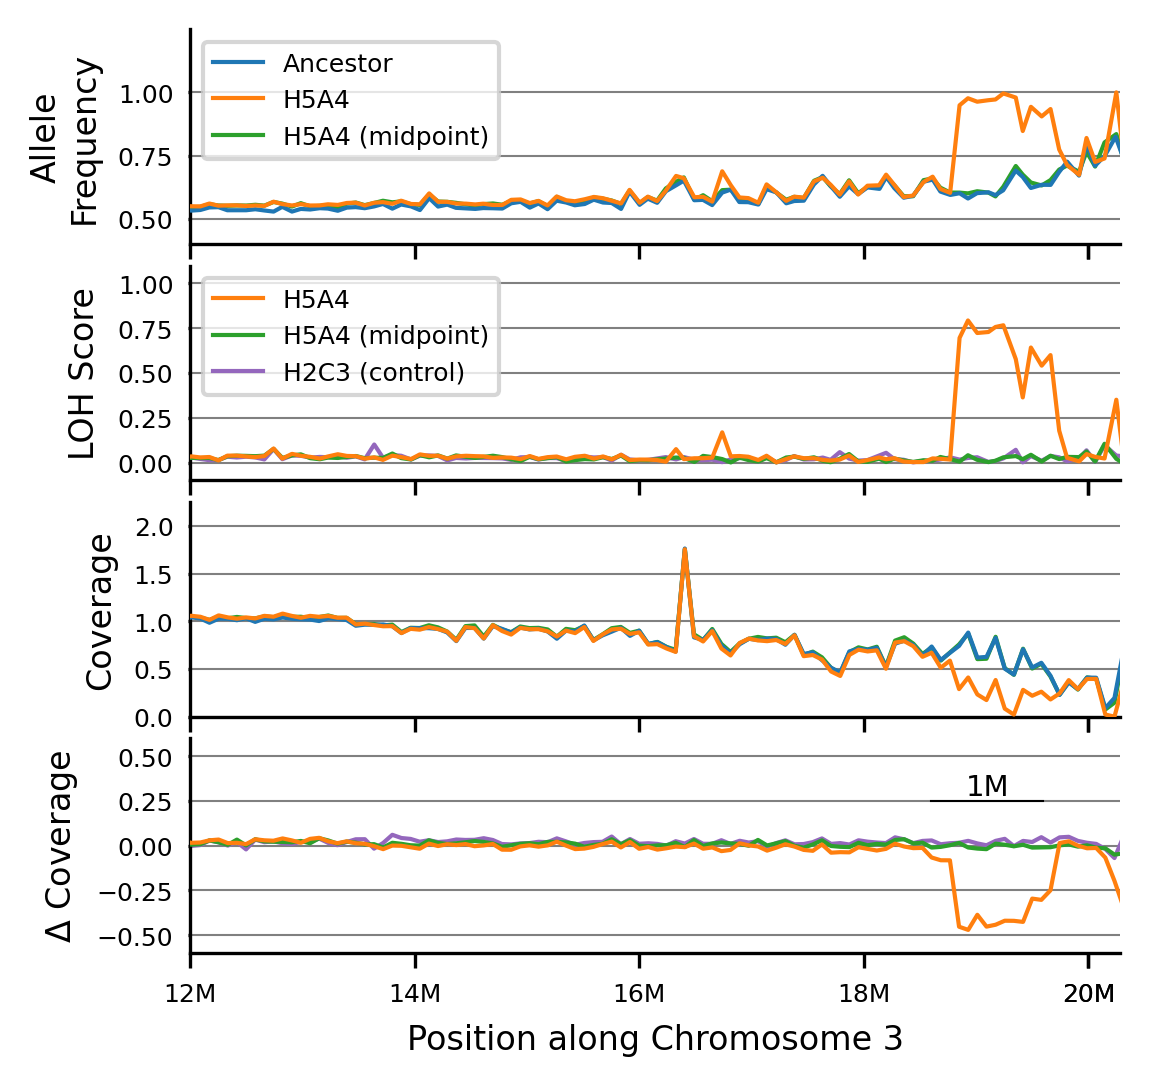

In [20]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_3", sample="H5A4",
    control_sample = "H2C3",
    lengths=lengths, colors=colors, lw=1.0,
    text=(18600000, 19600000, "M", 0.25, True, 0, 7),
    x_lim = (12e6, )
) # HET DELETION

# ME sample H4C2 C1 (Homozygous deletion)

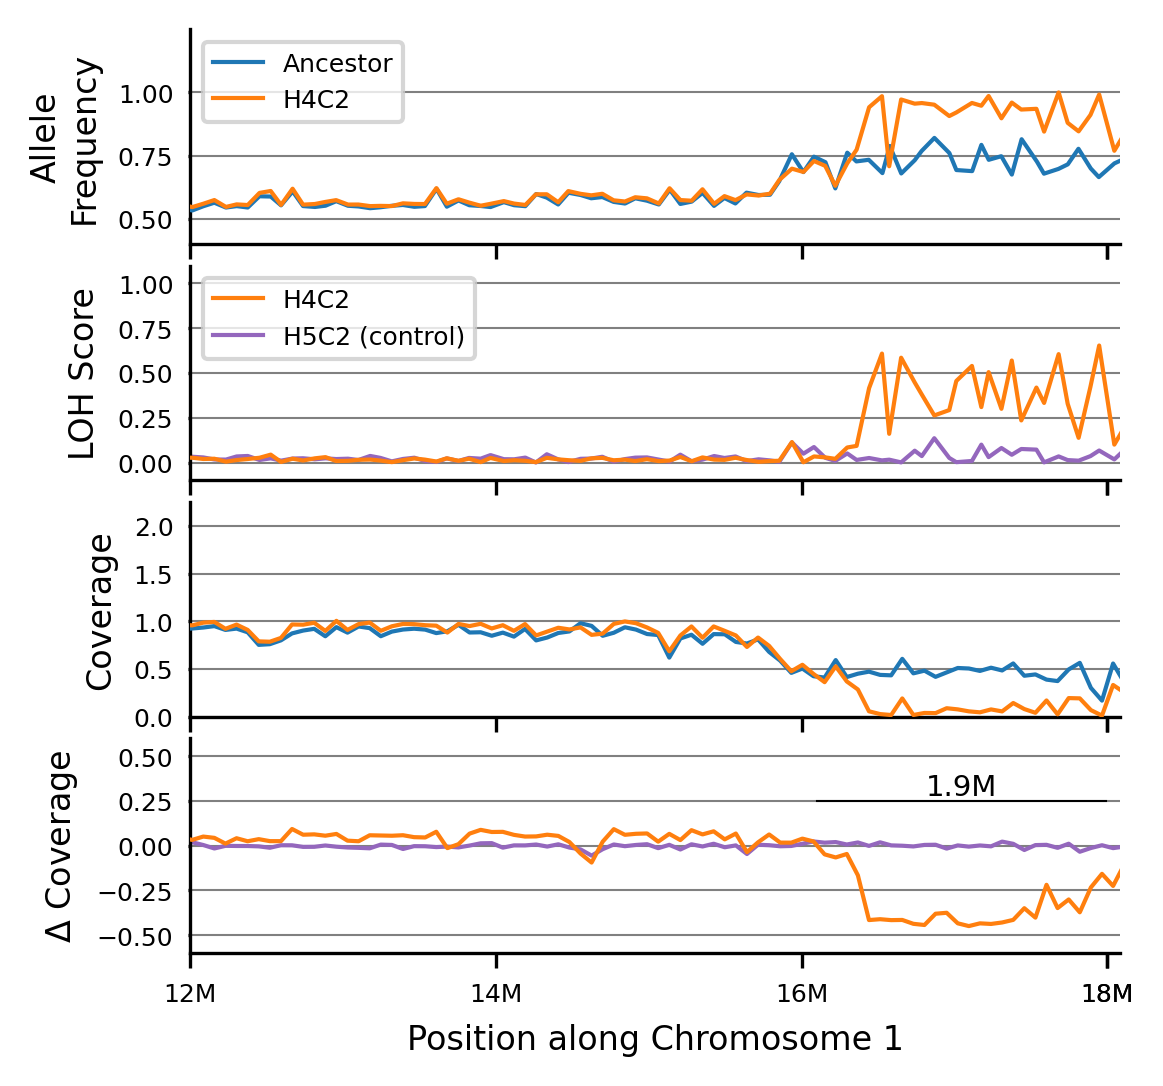

In [21]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_1", sample="H4C2",
    control_sample = "H5C2",
    lengths=lengths, colors=colors, lw=1.0,
    text=(16100000, 17990000, "M", 0.25, True, 1, 7),
    x_lim = (12e6, )
)

#### Alternative homozygous deletion: sample D5B3 C1

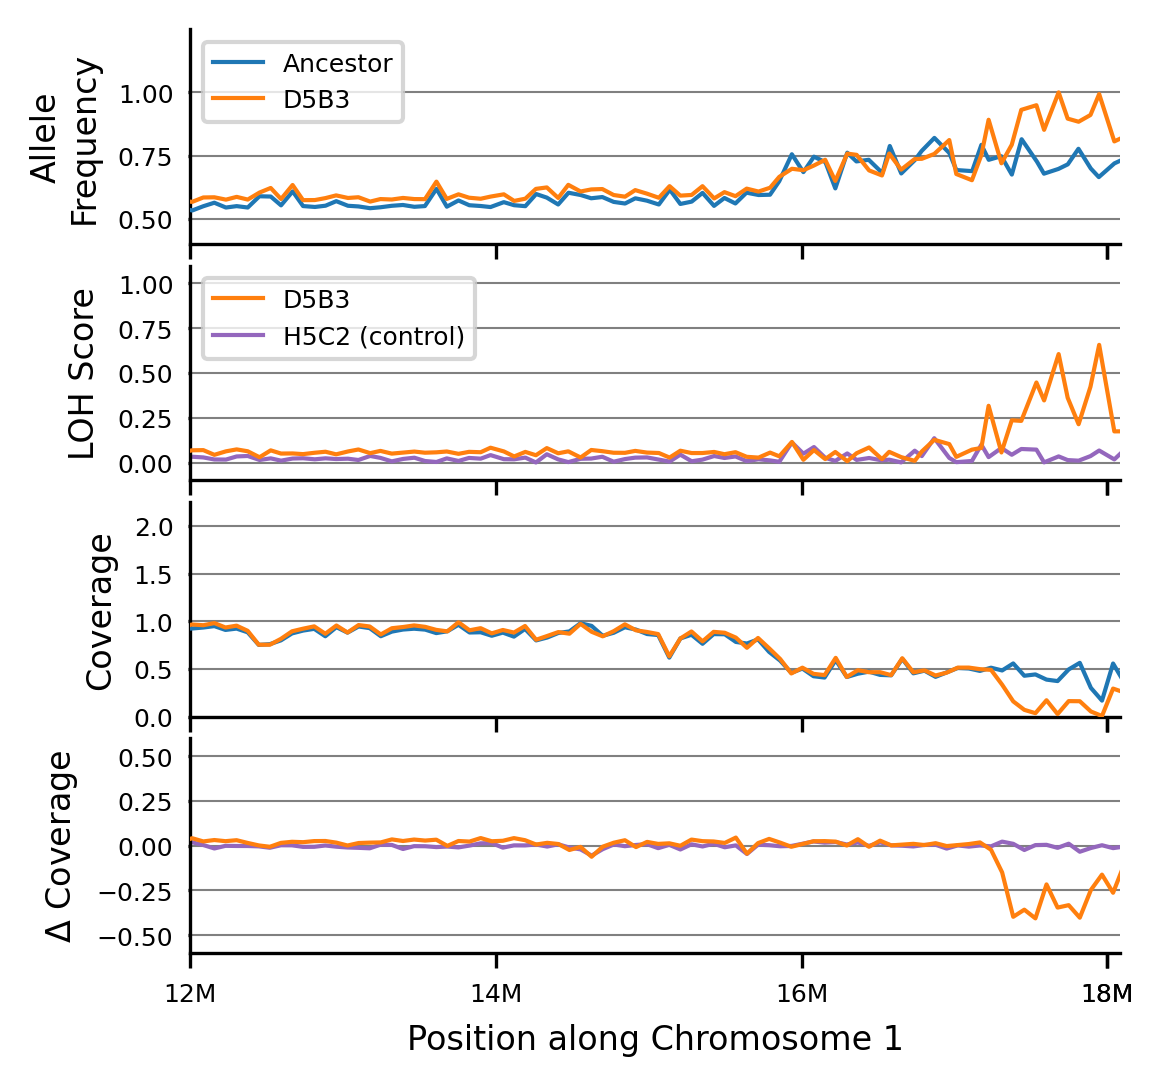

In [12]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_1", sample="D5B3",
    control_sample = "H5C2",
    lengths=lengths, colors=colors, lw=1.0,
    #text=(18600000, 19600000, "M", 0.25, True, 0, 7),
    x_lim = (12e6, )
) # HET DELETION

# ME sample D2B3 C1 (Restoration)

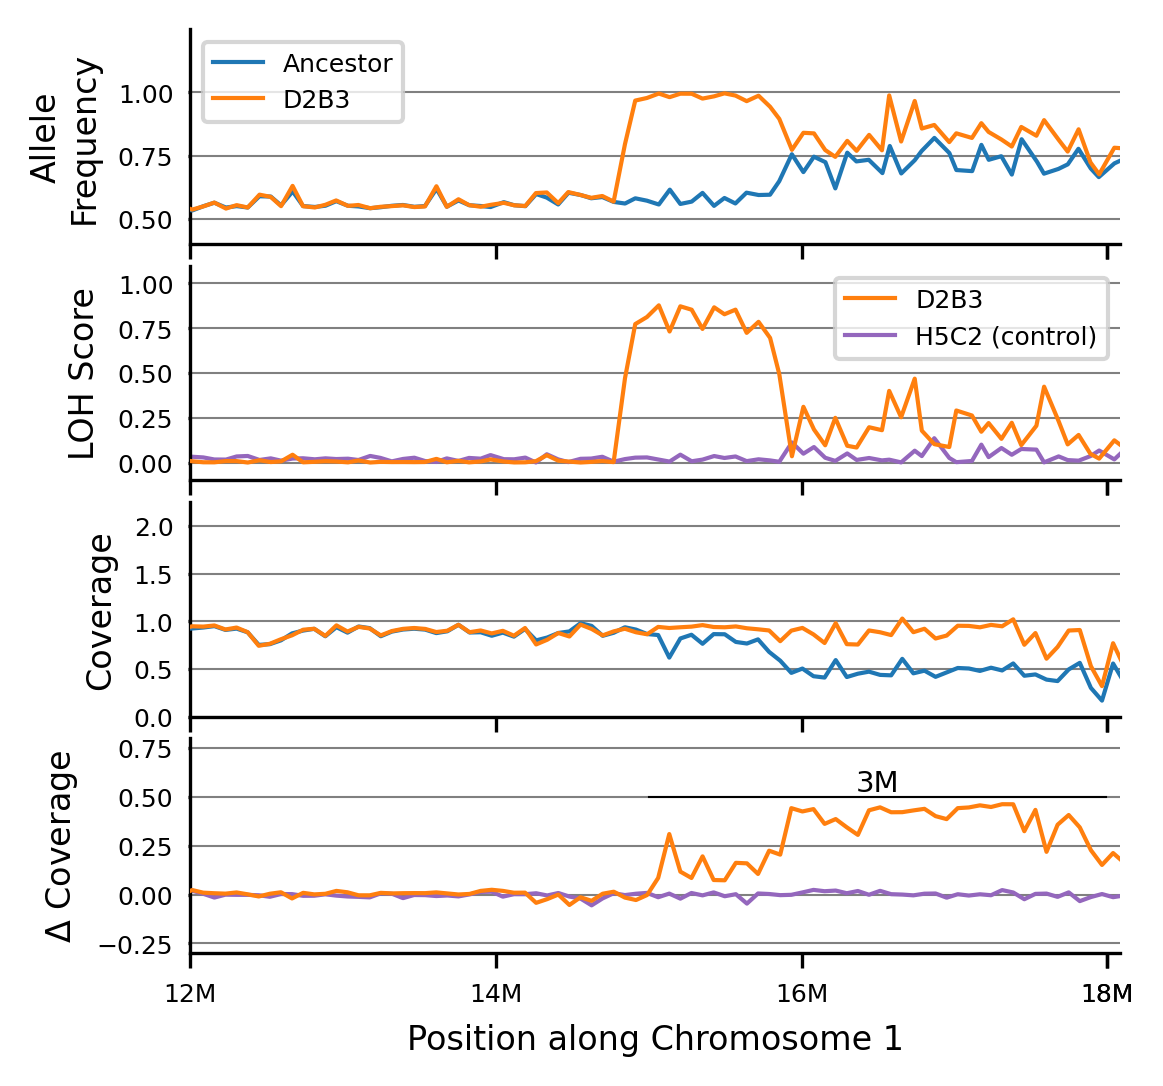

In [22]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_1", sample="D2B3",
    control_sample = "H5C2",
    lengths=lengths, colors=colors, lw=1.0,
    show_midpoint = False,
    cov_y_lim = (-0.3, 0.8),
    cov_y_ticks = [-0.25, 0.0, 0.25, 0.5, 0.75],
    text=(15000000, 17990000, "M", 0.5, True, 0, 7),
    x_lim = (12e6, )
)

# ME sample D2C1 C1 (Duplication)

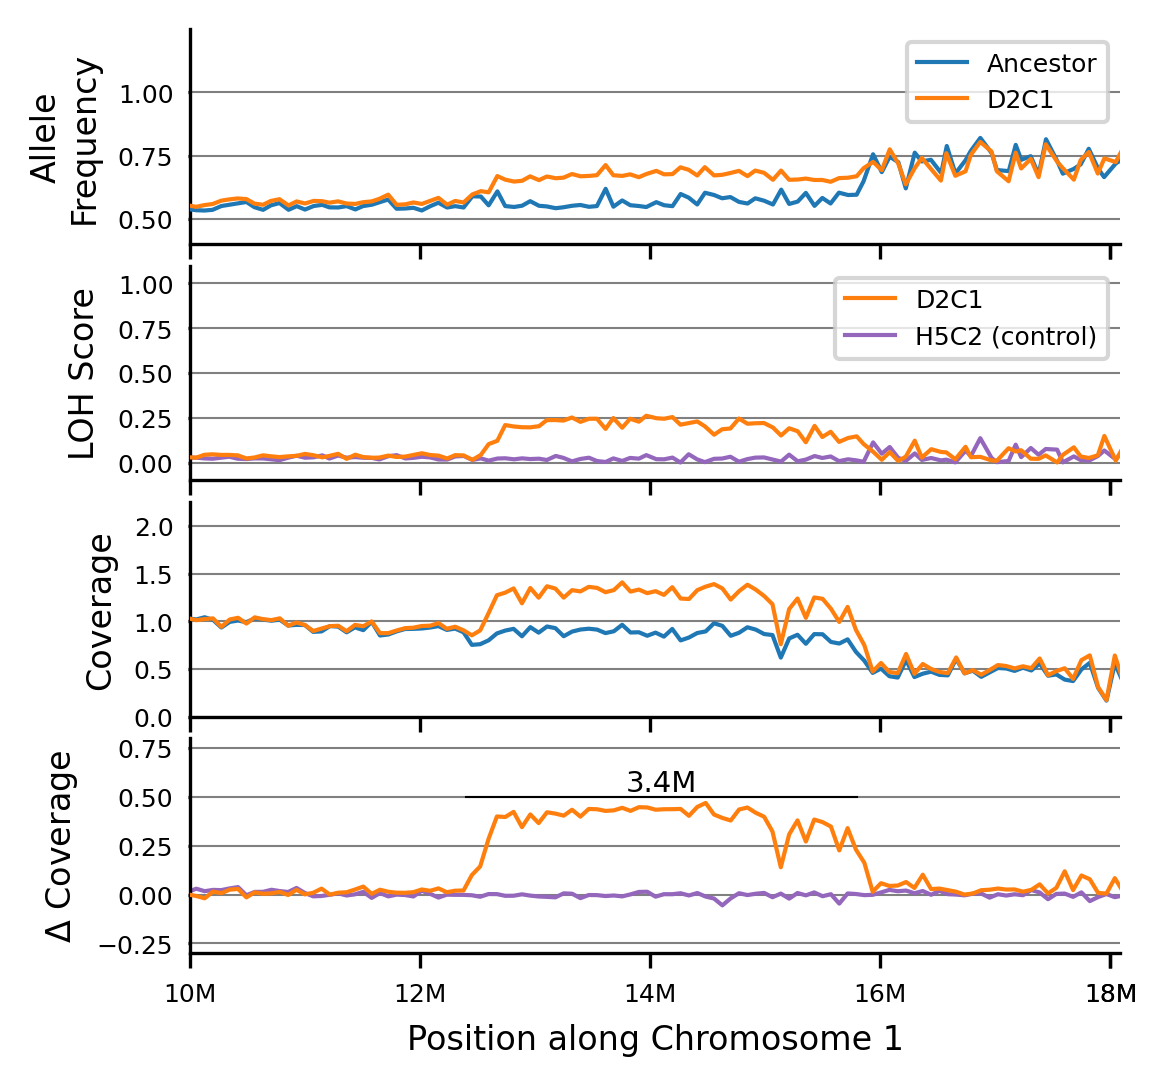

In [24]:
plot_data(
    summary_dir, all_files_per_sample,
    contig="Chrom_1", sample="D2C1",
    control_sample = "H5C2",
    lengths=lengths, colors=colors, lw=1.0,
    show_midpoint = False,
    cov_y_lim = (-0.3, 0.8),
    cov_y_ticks = [-0.25, 0.0, 0.25, 0.5, 0.75],
    text=(12400000, 15800000, "M", 0.5, True, 1, 7),
    x_lim = (10e6, )
)